# Data Science lighting talks (16.11.2021)

### Title: "A picture is worth...a multitude of analyses"

#### Description 

There was a time when our photos were nothing more than just a captured moment in time but nowadays there is a multitude of data stored, not just the photo itself. What information can we extract from our iPhone pictures and how? In this lightning talk, various approaches for mining photography data will be covered – all you need is just two things: Python and a laptop. (edited by Amrita Panesar)

___

#### <span style="color:blue">Table of contents:</span>
1. Read a HEIC image 
2.  Parse picture information from the EXIF headers 
    1. Camera info
    2. Camera settings
3. What does my picture contain?
    1. Object detection 
    2. Panoptic segmentation
    3. Image classification
    4. Text detection (OCR)
4. Recap
5. For another talk ...


___

**Code** available https://github.com/CarlitosDev/DSci_lighting_talk

**Questions** carlos.aguilar@ef.com, most likely you can find me at the coffee shop on Wednesdays

In [62]:
import os
import numpy as np
import cv2
import file_utils as fu
import image_utils as imgu
import computer_vision_utils as cvis
import geolocation_utils as geou

In [63]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]

### 1 - Read a HEIC image

  
  From https://www.macworld.co.uk/feature/what-is-heic-3660408/:
  
  "HEIC is the file format name Apple has chosen for the new HEIF standard. HEIF s
  tands for High Efficiency Image Format, and, as the name suggests, 
  is a more streamlined way of storing image files. Using advanced, 
  modern compression methods it allows digital photographs to be
  created in smaller files sizes, all while retaining higher image 
  quality than its JPEG alternative."

  Requirements: `pip3 install pyheif`

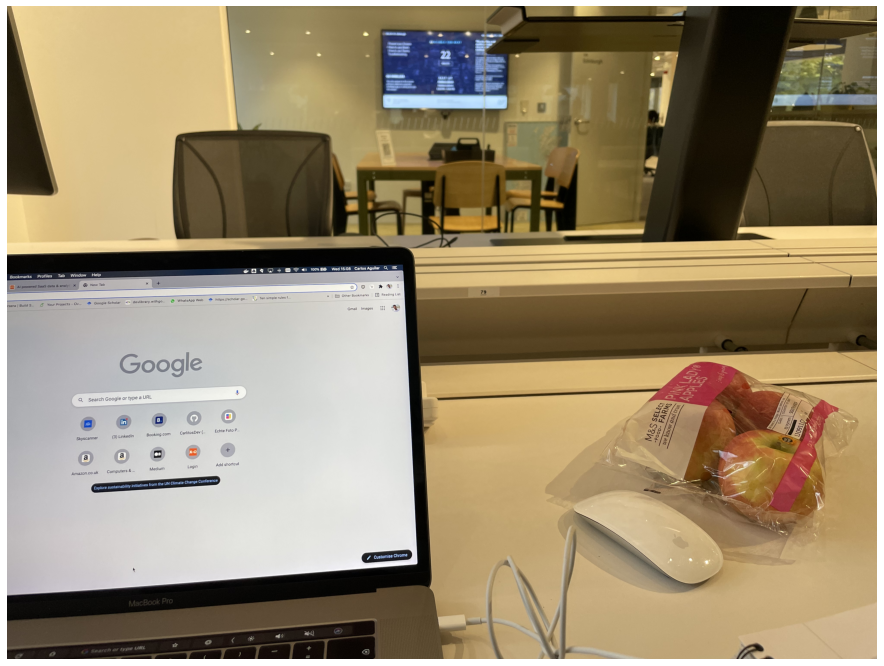

In [64]:
this_file_path = '/Volumes/GoogleDrive/My Drive/DataScience/lighting talk/Victoria_station.HEIC'
# this_file_path = '/Volumes/GoogleDrive/My Drive/DataScience/lighting talk/coffee_shop.HEIC'
# this_file_path = '/Volumes/GoogleDrive/My Drive/DataScience/lighting talk/IMG_9192.HEIC'
# this_file_path = '/Volumes/GoogleDrive/My Drive/DataScience/lighting talk/Boats_canal.HEIC'
this_file_path = '/Volumes/GoogleDrive/My Drive/DataScience/lighting talk/EFCMS.HEIC'


folder, fileName, fileExt = fu.fileparts(this_file_path)
image_info = dict(folder=folder,fileName=fileName,fileExt=fileExt)

this_image = imgu.load_heic_image_as_numpy(this_file_path)

imgu.show_image(this_image)

### 2 - Parse picture information from the EXIF headers

####  (2.a) - Camera maker and model and camera settings

  From https://www.wikiwand.com/en/Exif:
  >**EX**changeable **I**mage **F**ile format is a standard that specifies the formats for images,
  and ancillary tags used by digital cameras (including smartphones).

In [65]:
camera_info, camera_settings = imgu.get_EXIF_info_from_file(this_file_path)
fu.printJSON(camera_info)
image_info['camera_info'] = camera_info

{
  "Make": "Apple",
  "Model": "iPhone 12 mini",
  "Orientation": "Horizontal (normal)",
  "XResolution": "72",
  "YResolution": "72",
  "Software": "14.8",
  "DateTime": "2021:11:03 15:08:36"
}



In [66]:
fu.printJSON(camera_settings)
image_info['camera_settings'] = camera_settings

{
  "ExposureTime": "1/100",
  "FNumber": "8/5",
  "ISOSpeedRatings": "80",
  "ComponentsConfiguration": "YCbCr",
  "ShutterSpeedValue": "61069/9192",
  "ApertureValue": "14447/10653",
  "Flash": "Flash did not fire, auto mode",
  "FocalLength": "21/5",
  "ExifImageWidth": "4032",
  "ExifImageLength": "3024",
  "SceneType": "Directly Photographed",
  "ExposureMode": "Auto Exposure",
  "LensMake": "Apple",
  "LensModel": "iPhone 12 mini back dual wide camera 4.2mm f/1.6"
}



#### (2.b) - Parse the geographical information contained in the EXIF headers

> EXIF-Geolocation

The Exif format has standard tags for location information.
Mobile phones have a built-in GPS receiver that stores the location 
information in the Exif header when a picture is taken.

Requirements:
`pip3 install geopy`

In [67]:
# 1.b.1 - GPS info from EXIF
exif_gps_info = imgu.get_GPS_EXIF_info_from_file(this_file_path)
fu.printJSON(exif_gps_info)
image_info['exif_gps_info'] = exif_gps_info

{
  "latitude_tag": "51 29' 12.65'' N",
  "lat_ref": "N",
  "lat_values": [
    "51",
    " 29",
    " 253/20"
  ],
  "lat_degrees": 51,
  "lat_minutes": 29,
  "lat_seconds": 12.65,
  "longitude_tag": "0 10' 1.9'' W",
  "latitude_dec": 51.486847222222224,
  "lon_ref": "W",
  "lon_values": [
    "0",
    " 10",
    " 19/10"
  ],
  "lon_degrees": 0,
  "lon_minutes": 10,
  "lon_seconds": 1.9,
  "longitude_dec": -0.16719444444444442,
  "datetime_tag": "2021:11:03 15:08:36"
}



In [68]:
# 1.b.2 - From coordinates to location
location_info = geou.reverse_coordinates_geopy(exif_gps_info['latitude_dec'], exif_gps_info['longitude_dec'])
fu.printJSON(location_info)
image_info['location_info'] = location_info

{
  "amenity": "EF Regional Hub",
  "house_number": "22",
  "road": "Chelsea Manor Street",
  "suburb": "Chelsea",
  "city_district": "Royal Borough of Kensington and Chelsea",
  "city": "London",
  "state_district": "Greater London",
  "state": "England",
  "postcode": "SW3 5RL",
  "country": "United Kingdom",
  "country_code": "gb"
}



### 3 - What does my picture contain?

#### 3.1 - Object detection  
Requirements:
`pip3 install --upgrade torchvision torch`

Use YoloV5 by Utralytics: https://docs.ultralytics.com/  
(there's some controversy about this release of Yolo)

See the available models in https://pytorch.org/hub/ultralytics_yolov5/

Organise the objects per class, ie: the key 'chair' 
will be a list of N detected items.

In [69]:
import torch
import torchvision
model = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=True)
results = model(this_image)


df_results = results.pandas().xyxy[0]
_cols = ['xmin', 'ymin', 'xmax', 'ymax', 'confidence']

detected_objects = {}
for idx, iRow in df_results.iterrows():
  detected_objects.setdefault(iRow['name'], []).append(iRow[_cols].to_dict())

image_info['detected_objects'] = detected_objects

objects_and_quantity = {k: len(v) for k,v in detected_objects.items()}
print('Breakdown of found objects: ')
fu.printJSON(objects_and_quantity)

Using cache found in /Users/carlos.aguilar/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-8-16 torch 1.9.1 CPU

Fusing layers... 
Model Summary: 290 layers, 21172173 parameters, 0 gradients, 49.0 GFLOPs
Adding AutoShape... 


Breakdown of found objects: 
{
  "chair": 5,
  "mouse": 1,
  "tv": 2,
  "laptop": 1,
  "person": 1
}



In [70]:
current_object = [*objects_and_quantity.keys()][0]
print(f'In detail...coordinates and confidence for object {current_object}')
fu.printJSON(detected_objects[current_object][0])

In detail...coordinates and confidence for object chair
{
  "xmin": 2301.42578125,
  "ymin": 647.6749877929688,
  "xmax": 2657.7392578125,
  "ymax": 1050.8978271484375,
  "confidence": 0.8918182849884033
}



#### 3.2 - Panoptic segmentation (**Detectron2** by Facebook)

Requirements:
`pip3 install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html`

OR manual install:

```
cd /Users/carlos.aguilar/Documents/Detectron2
git clone https://github.com/facebookresearch/detectron2
cd detectron2
source ~/.bash_profile && python3 setup.py install
```

In [71]:
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

setup_logger()

cfg = get_cfg()
cfg.MODEL.DEVICE = 'cpu'

cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_1x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_1x.yaml")
predictor = DefaultPredictor(cfg)

[Checkpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_50_1x/139514544/model_final_dbfeb4.pkl ...
Reading a file from 'Detectron2 Model Zoo'


/Users/carlos.aguilar/Documents/EF_repos/DSci_lighting_talk/src/image_utils.py:65: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


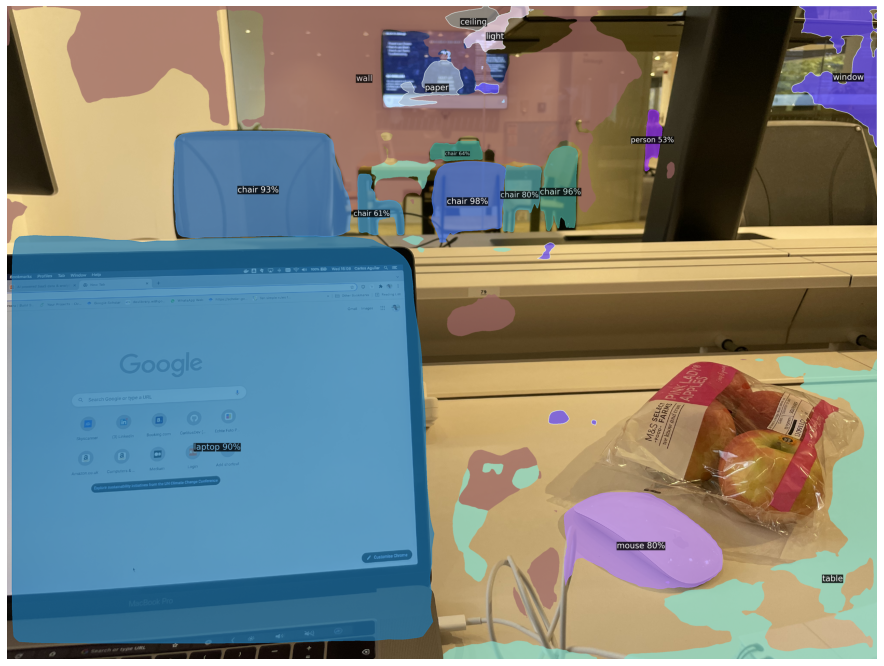

In [72]:
outputs = predictor(this_image)
panoptic_seg, segments_info = outputs["panoptic_seg"]
v = Visualizer(this_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)

out_image = out.get_image()[:, :, ::-1]
imgu.show_image(out_image)

In [73]:
# 'translate' the segments info
total_area = float(this_image.shape[0]*this_image.shape[1])

metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
for sinfo in segments_info:
  category_idx = sinfo["category_id"]
  sinfo['percentage_area'] = sinfo['area']/total_area

  if sinfo['isthing']:
    text = metadata.thing_classes[category_idx]
  else:
    text = metadata.stuff_classes[category_idx]
  sinfo['object'] = text

fu.printJSON(segments_info[0:2])
image_info['segmented_objects'] = segments_info

{
  "id": 1,
  "isthing": true,
  "score": 0.982528805732727,
  "category_id": 56,
  "instance_id": 0,
  "area": 102869.0,
  "percentage_area": 0.008436886521583942,
  "object": "chair"
}

{
  "id": 2,
  "isthing": true,
  "score": 0.9594557285308838,
  "category_id": 56,
  "instance_id": 1,
  "area": 52350.0,
  "percentage_area": 0.00429352875409423,
  "object": "chair"
}

Error



#### 3.3 Image classification

From here https://huggingface.co/google/vit-base-patch16-224:  
Use this model to **classify** an image of the COCO 2017 dataset into one of the 1,000 ImageNet classes.

BibTeX refs:
```@misc{wu2020visual,
    title={Visual Transformers: Token-based Image Representation and Processing for Computer Vision}, 
    author={Bichen Wu, Chenfeng Xu, Xiaoliang Dai, Alvin Wan, Peizhao Zhang, Zhicheng Yan, Masayoshi Tomizuka, Joseph Gonzalez, Kurt Keutzer, Peter Vajda},
    year={2020},
    eprint={2006.03677},
    archivePrefix={arXiv},
    primaryClass={cs.CV}
}
```

Requires:
`pip3 install transformers`

In [74]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [75]:
inputs = feature_extractor(images=this_image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
dominant_class = model.config.id2label[predicted_class_idx].upper()
print(f'>>> Image tagged as {dominant_class}')
image_info['dominant_class'] = dominant_class

>>> Image tagged as DESK


#### 3.4 Text detection (OCR). <span style="color:green">fixed ;)</span>

Pytesseract calls Google's Tesseract OCR engine (https://opensource.google/projects/tesseract)

`brew install tesseract` and `pip3 install pytesseract --upgrade`

In [76]:
import pytesseract
# --psm page segmentation mode; --oem OCR Engine mode. See https://wilsonmar.github.io/tesseract/
custom_config = r'--oem 3 --psm 11'
df_text = pytesseract.image_to_data(this_image, lang='eng', config=custom_config, output_type=pytesseract.Output.DATAFRAME)
idx_A=df_text.conf >= 92
df_text = df_text[idx_A].copy()
df_text.reset_index(drop=True, inplace=True)
recognised_text = df_text.text.tolist()
image_info['text_OCR'] = recognised_text

Text:
  -Tab
  -Window
  -Help
  -+
  -data
  -&
  -New
  -Tab
  -Bookmarks
  -Reading
  -List
  -79
  -Ten
  -simple
  -rules
  -Google
  -Scholar
  -Web
  -rsera
  -|
  -Build
  -Your
  -Projects
  -Gmail
  -Google
  -Google
  -or
  -type
  -URL
  -Foto
  -P.
  -Booking.com
  -Skyscanner
  -(3)
  -+
  -a
  -a
  -Add
  -shortcut
  -Medium
  -Login
  -Amazon.co.uk
  -Computers
  -&


/Users/carlos.aguilar/Documents/EF_repos/DSci_lighting_talk/src/image_utils.py:65: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


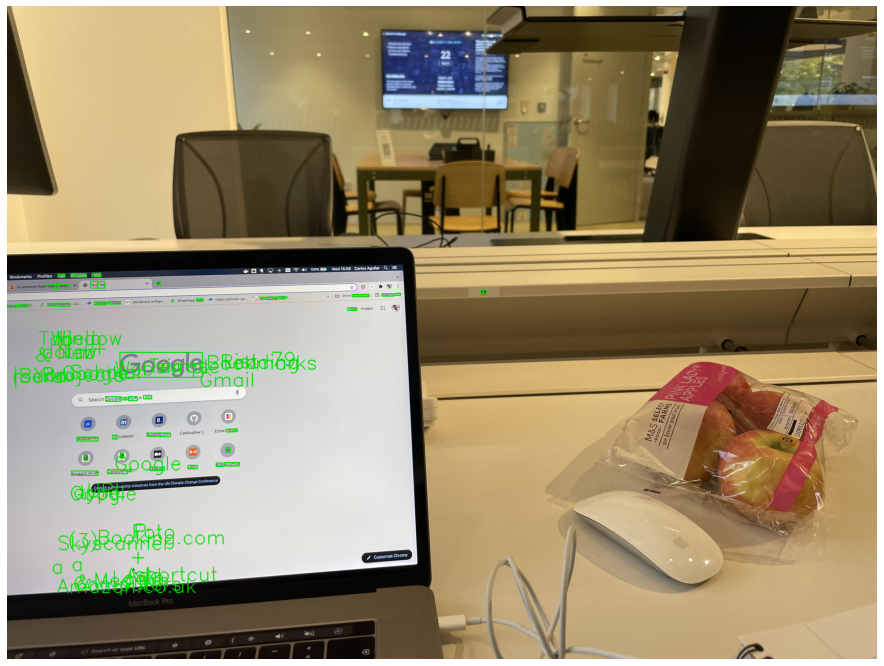

In [77]:
bounded = this_image.copy()
img_h, img_w, _ = bounded.shape

font      = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 3
fontColor = (0,222,0)
thickness = 3
lineType  = 2

print('Text:')
for _,iRow in df_text.iterrows():
    print(f'  -{iRow.text}')
    leftCorner = (iRow.left, iRow.top)
    boxExtent = (iRow.left+iRow.width, iRow.top+iRow.height)
    cv2.rectangle(bounded,leftCorner , boxExtent, fontColor, 3)
    cv2.putText(bounded,iRow.text, 
                (int(boxExtent[0]*0.55), int(boxExtent[1]*1.25)), 
                font, fontScale,fontColor,thickness,lineType)

imgu.show_image(bounded)

## Recap

In [78]:
print(f'From image {fileName}, we have extracted:')
print('\n -'.join([*image_info.keys()]))

From image EFCMS, we have extracted:
folder
 -fileName
 -fileExt
 -camera_info
 -camera_settings
 -exif_gps_info
 -location_info
 -detected_objects
 -segmented_objects
 -dominant_class
 -text_OCR


## For another talk ...
- face detection and recognition
- embeddings
- QA on images
- put it all together in a DB